In [1]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
import os
import librosa
import librosa.display
import glob 
import skimage

In [4]:
# 读取数据
df = pd.read_csv("D:/Content_Secu/task2/input/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
# 读取两个音频文件，用于后续处理
dat1, sampling_rate1 = librosa.load('D:/Content_Secu/task2/input/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('D:/Content_Secu/task2/input/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

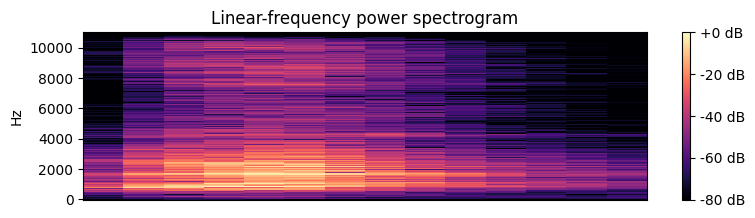

In [6]:
# 生成两个音频文件的线性频率功率谱图
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

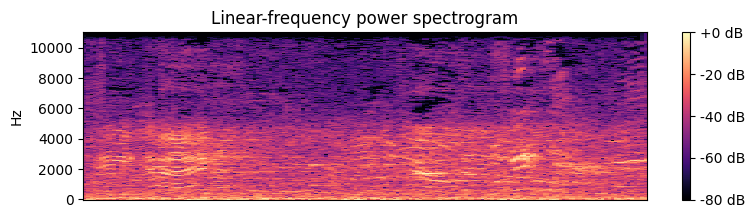

In [7]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

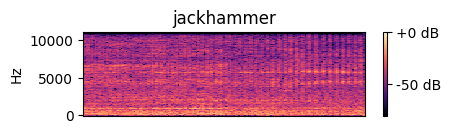

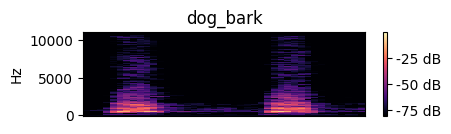

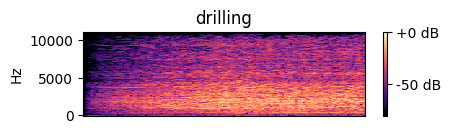

In [8]:
# 使用随机样本来观察波形差异
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

# 循环处理随机选择的音频文件，展示它们的谱图和类别
for i in range(192, 197, 2):
    path = 'D:/Content_Secu/task2/input/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

In [9]:
# 读取一个音频文件，并获取它的Mel频谱
dat1, sampling_rate1 = librosa.load('D:/Content_Secu/task2/input/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 14)

In [10]:
# 初始化特征和标签列表
feature = []
label = []

# 定义解析函数，用于从DataFrame中提取音频特征和标签
def parser(df):
    features = []
    labels = []
    for i in range(len(df)):
        file_name = f'D:/Content_Secu/task2/input/fold{df["fold"].iloc[i]}/{df["slice_file_name"].iloc[i]}'
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)        
        features.append(mels)
        labels.append(df["classID"].iloc[i])
    
    features = np.array(features, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    return features, labels

In [11]:
# 调用解析函数处理数据集，并获取特征和标签
features, labels = parser(df)

C:\Users\35083\.conda\envs\tensorflow\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
C:\Users\35083\.conda\envs\tensorflow\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
C:\Users\35083\.conda\envs\tensorflow\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [12]:
# 将标签转换为one-hot编码，用于多分类
labels = to_categorical(labels)

In [13]:
# 打印最终的特征和标签数组的形状
print(features.shape)
print(labels.shape)

(8732, 128)
(8732, 10)


In [14]:
# 将数据集划分为训练集和测试集，测试集比例为20%
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [15]:
# 计算训练集和测试集的样本数量
n_samples_train = X_train.shape[0]  # 训练集样本数
n_samples_test = X_test.shape[0]  # 测试集样本数

# 重塑X_train和X_test以适配模型的输入形状
# 保证总的元素个数不变，这里128等于16*8，所以将每个样本重塑为(16, 8, 1)形状
X_train = X_train.reshape(n_samples_train, 16, 8, 1)
X_test = X_test.reshape(n_samples_test, 16, 8, 1)


In [16]:
# 设置模型输入的维度
input_dim = (16, 8, 1)

In [17]:
# 构建Sequential模型
model = Sequential()

In [18]:
# 向模型中添加卷积层、池化层和dropout层
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
# 展平特征图以传入全连接层
model.add(Flatten())
# 添加全连接层，最后是输出层，用softmax激活函数进行分类
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

In [19]:
# 编译模型，设置优化器、损失函数和评估指标
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [20]:
# 训练模型，设置训练周期、批量大小和验证数据
model.fit(X_train, Y_train, epochs = 90, batch_size = 50, validation_data = (X_test, Y_test))

Epoch 1/90
140/140 [==============================] - 7s 42ms/step - loss: 1.5314 - accuracy: 0.4852 - val_loss: 1.2844 - val_accuracy: 0.5621
Epoch 2/90
140/140 [==============================] - 6s 40ms/step - loss: 1.1203 - accuracy: 0.6225 - val_loss: 1.0923 - val_accuracy: 0.6400
Epoch 3/90
140/140 [==============================] - 5s 39ms/step - loss: 0.9566 - accuracy: 0.6785 - val_loss: 0.9760 - val_accuracy: 0.6709
Epoch 4/90
140/140 [==============================] - 6s 40ms/step - loss: 0.8374 - accuracy: 0.7211 - val_loss: 0.9300 - val_accuracy: 0.7052
Epoch 5/90
140/140 [==============================] - 6s 40ms/step - loss: 0.7284 - accuracy: 0.7560 - val_loss: 0.8685 - val_accuracy: 0.7367
Epoch 6/90
140/140 [==============================] - 6s 40ms/step - loss: 0.6727 - accuracy: 0.7729 - val_loss: 0.8753 - val_accuracy: 0.7321
Epoch 7/90
140/140 [==============================] - 6s 40ms/step - loss: 0.6382 - accuracy: 0.7888 - val_loss: 0.8581 - val_accuracy: 0.7539

Epoch 58/90
140/140 [==============================] - 5s 35ms/step - loss: 0.0892 - accuracy: 0.9698 - val_loss: 0.9673 - val_accuracy: 0.8546
Epoch 59/90
140/140 [==============================] - 5s 36ms/step - loss: 0.0843 - accuracy: 0.9718 - val_loss: 0.8897 - val_accuracy: 0.8638
Epoch 60/90
140/140 [==============================] - 5s 34ms/step - loss: 0.0856 - accuracy: 0.9704 - val_loss: 0.8795 - val_accuracy: 0.8626
Epoch 61/90
140/140 [==============================] - 6s 39ms/step - loss: 0.0905 - accuracy: 0.9702 - val_loss: 0.9037 - val_accuracy: 0.8546
Epoch 62/90
140/140 [==============================] - 6s 41ms/step - loss: 0.0946 - accuracy: 0.9675 - val_loss: 0.9074 - val_accuracy: 0.8546
Epoch 63/90
140/140 [==============================] - 6s 40ms/step - loss: 0.0782 - accuracy: 0.9719 - val_loss: 0.8688 - val_accuracy: 0.8666
Epoch 64/90
140/140 [==============================] - 6s 41ms/step - loss: 0.0774 - accuracy: 0.9735 - val_loss: 0.8352 - val_accuracy:

In [21]:
# 打印模型概览
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 64)         640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 2, 128)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 2, 128)         0         
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [22]:
# 使用测试集进行预测
predictions = model.predict(X_test)
# 评估模型性能，输出损失值和准确率
score = model.evaluate(X_test, Y_test)
print(score)

55/55 [==============================] - 0s 3ms/step - loss: 0.9106 - accuracy: 0.8718
[0.9105537533760071, 0.8717802166938782]


In [23]:
# 将预测结果转换为标签
preds = np.argmax(predictions, axis = 1)

In [24]:
# 将预测结果保存为pandas DataFrame，并写入CSV文件
result = pd.DataFrame(preds)
result.to_csv("UrbanSound8kResults.csv")